# Classifying into TV Show or Movie 

## Importing libraries

In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.pipeline import Pipeline
import plotly.graph_objects as go
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
  

In [2]:
netflix_data = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
netflix_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


### Checking for null values

In [4]:
netflix_data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

## Plotting different bar plots 

In [16]:
ratings       = list(netflix_data['rating'].value_counts().index)
rating_counts = list(netflix_data['rating'].value_counts().values)

# Plotly bar plot
fig = go.Figure(data=[go.Bar(
    x=ratings,
    y=rating_counts,
    
)])

# Set layout
fig.update_layout(
    title='Movie Ratings Distribution',
    xaxis_title='Rating',
    yaxis_title='Count',
    
    
)

# Display the plot
fig.show()

In [17]:
movie_counts = netflix_data['release_year'].value_counts().sort_index()
# Create the bar chart
fig = go.Figure(data=go.Bar(x=movie_counts.index, y=movie_counts.values))

fig.update_layout(
    title='Number of Movies Released Each Year',  # Chart title
    xaxis=dict(title='Year'),  # X-axis label
    yaxis=dict(title='Number of Movies')  # Y-axis label
)

fig.show()

In [18]:
ratings       = list(netflix_data['duration'].value_counts().index)
rating_counts = list(netflix_data['duration'].value_counts().values)

# Plotly bar plot
fig = go.Figure(data=[go.Bar(
    x=ratings,
    y=rating_counts,
)])

# Set layout
fig.update_layout(
    title='Movie Durations Distribution',
    xaxis_title='Rating',
    yaxis_title='Count',
    
)

# Display the plot
fig.show()

## Most common words in Netflix titles

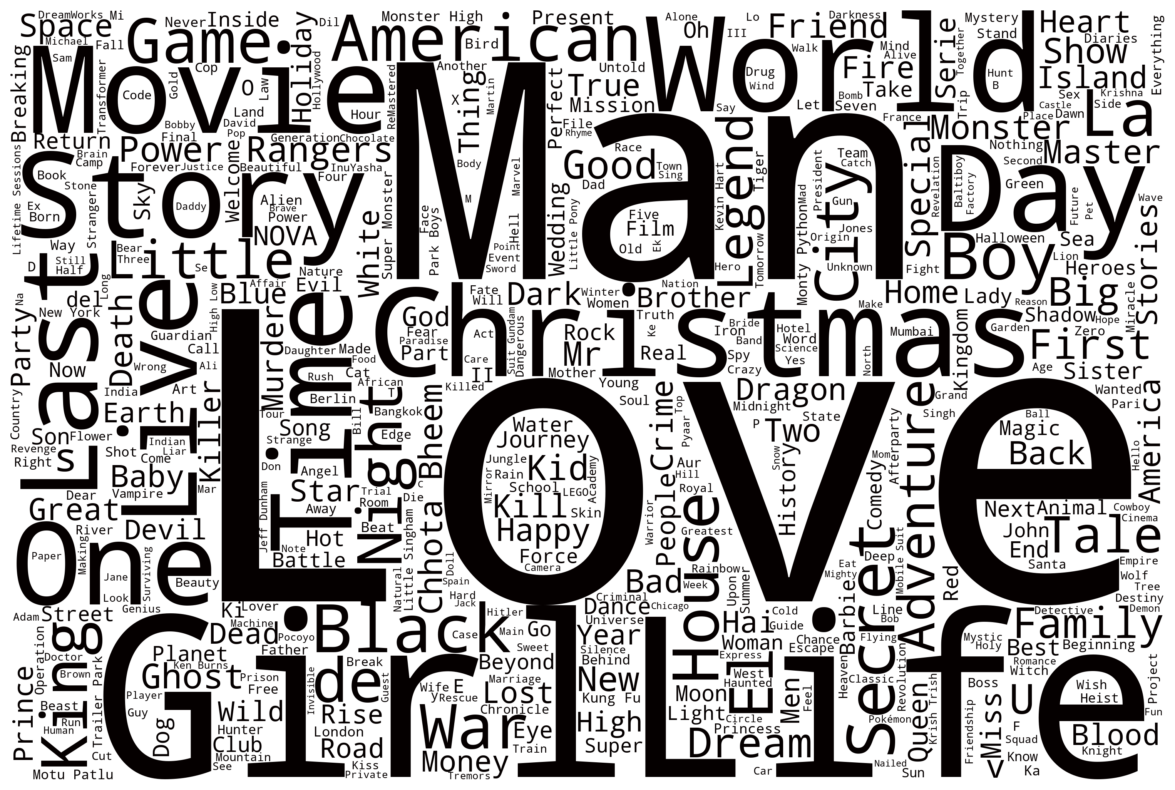

In [19]:
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
# Extract titles from the Netflix dataset
titles = netflix_data['title'].values

# Combine all titles into a single string
text = ' '.join(titles)
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate(text)
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
# save the image
plt.savefig('biden_wc.png')

## Most common words in Description

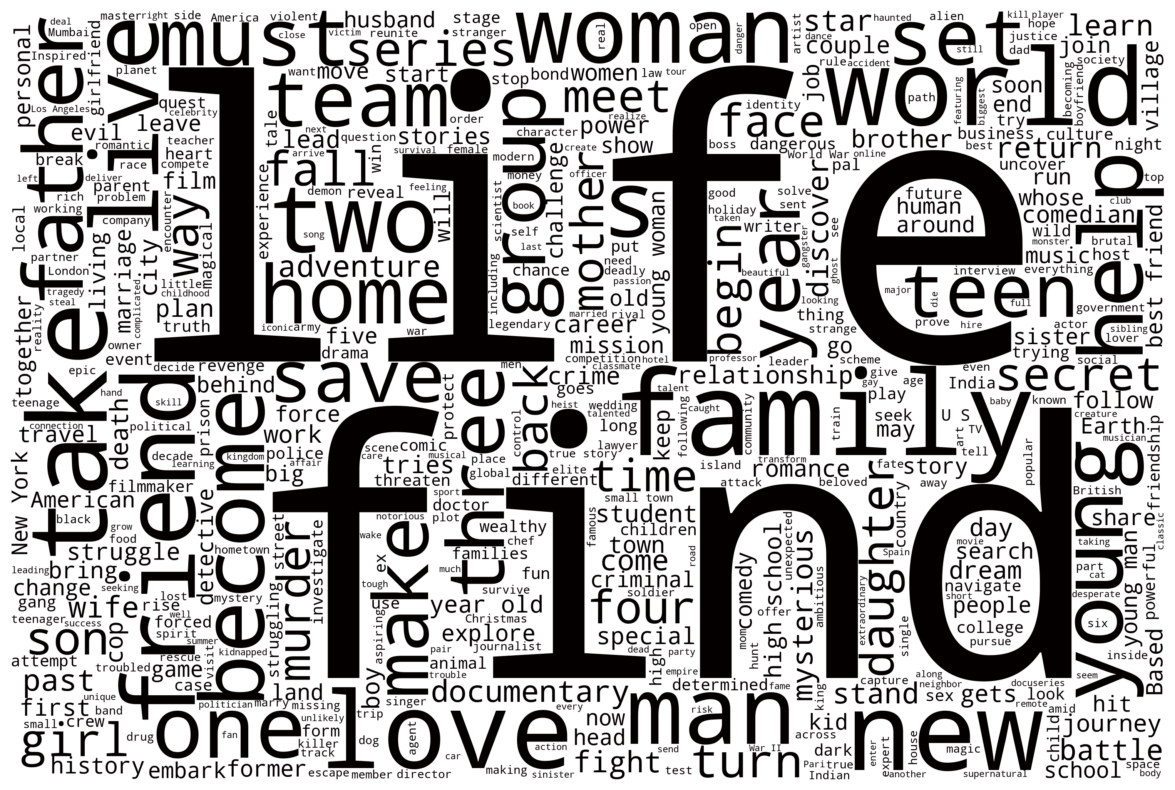

In [20]:
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
# Extract titles from the Netflix dataset
titles = netflix_data['description'].values
# Combine all titles into a single string
text = ' '.join(titles)
wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate(text)
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")

# save the image
plt.savefig('biden_wc.png')


## Cleaning textual data 

In [5]:
class TextCleaner:
    def separate_text(self, texts):
        unique_texts = set()
        for text in texts.split(','):
            unique_texts.add(text.strip().lower())
        return ' '.join(unique_texts)

    def remove_space(self, texts):
        return texts.replace(' ', '').lower()

    def remove_punc(self, texts):
        texts = texts.lower()
        texts = texts.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(texts.split())

    def clean_text(self, texts):
        texts = self.separate_text(texts)
        texts = self.remove_space(texts)
        texts = self.remove_punc(texts)
        return texts

In [6]:
cleaner = TextCleaner()

In [7]:
netflix_data['text'] = (
    'director: ' + netflix_data['director'].fillna('') + '\n' +
    ' cast : ' + netflix_data['cast'].fillna('') + '\n' +
    ' description: ' + netflix_data['description'].fillna('') + '\n' 
)
netflix_data['text']

0       director: Kirsten Johnson\n cast : \n descript...
1       director: \n cast : Ama Qamata, Khosi Ngema, G...
2       director: Julien Leclercq\n cast : Sami Bouaji...
3       director: \n cast : \n description: Feuds, fli...
4       director: \n cast : Mayur More, Jitendra Kumar...
                              ...                        
8802    director: David Fincher\n cast : Mark Ruffalo,...
8803    director: \n cast : \n description: While livi...
8804    director: Ruben Fleischer\n cast : Jesse Eisen...
8805    director: Peter Hewitt\n cast : Tim Allen, Cou...
8806    director: Mozez Singh\n cast : Vicky Kaushal, ...
Name: text, Length: 8807, dtype: object

In [8]:
netflix_data['text']=netflix_data['text'].apply(cleaner.clean_text)


In [9]:
netflix_data

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,text
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",directorkirstenjohnson cast descriptionasherfa...
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",acapetownteensetsouttoprovewhetheraprivatescho...
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,bakarydiombera descriptiontoprotecthisfamilyfr...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",flirtationsandtoilettalkgodownamongtheincarcer...
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,anearnestbutunexceptionalstudentandhisfriendsn...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",briancoxeliaskoteasacrimereporterandapairofcop...
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",ayounggirlbefriendsamotleycrewofzombiechildren...
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,emmastonebillmurrayadorkycollegestudentteamswi...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",chevychaseriptorndirectorpeterhewitt casttimal...


### Separating target variable and input variable

In [10]:
X=netflix_data['text']
y=netflix_data['type']

## Train test split

In [11]:
X_train, X_test,y_train, y_test = train_test_split(X,y,random_state=12,test_size=0.20)

## Hyper Parameter tuning using optuna

In [ ]:
def objective(trial):
    
    param = {
        "random_state":12,
         "n_estimators":trial.suggest_int("n_estimators",50,20000),
         "learning_rate":trial.suggest_float("learning_rate",0.0001,1),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    lgb_model = Pipeline((("vect", TfidfVectorizer()),("clc", lgb.LGBMClassifier(**param))))
    
    pred=lgb_model.fit(X_train,y_train)
    y_pred=lgb_model.predict(X_test)
    
    return accuracy_score(y_test, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## Tfidfvectorizer+LGBM Classifier

In [12]:
lgb_model = Pipeline((("vect", TfidfVectorizer()),("clc", lgb.LGBMClassifier(**param))))

## Fitting the model with LGBM classifier

In [13]:
pred=lgb_model.fit(X_train,y_train)

## Predictions

In [14]:
y_pred=lgb_model.predict(X_test)

## Calculating accuracy score

In [15]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7628
